In [1]:
import seaborn
import matplotlib
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas
import pathlib

# Accuracies

In [2]:
!ls *.npy

lava_accuracy_noDelay_bias_zero.npy
lava_activity_noDelay_bias_zero.npy
nengo_accuracy_noDelay_bias_zero.npy
nengo_accuracy_noDelay_noBias_subtract.npy
nengo_activity_noDelay_bias_zero.npy
nengo_activity_noDelay_noBias_subtract.npy
norse_accuracy_noDelay_bias_zero.npy
norse_accuracy_noDelay_noBias_subtract.npy
norse_activity_noDelay_bias_zero.npy
norse_activity_noDelay_noBias_subtract.npy
rockpool_accuracy_noDelay_noBias_subtract.npy
rockpool_activity_noDelay_noBias_subtract.npy
s2_accuracy_noDelay_bias_zero.npy
s2_accuracy_noDelay_noBias_subtract.npy
s2_activity_noDelay_bias_zero.npy
s2_activity_noDelay_noBias_subtract.npy
snntorch_accuracy_noDelay_bias_zero.npy
snntorch_accuracy_noDelay_noBias_subtract.npy
snntorch_activity_noDelay_bias_zero.npy
snntorch_activity_noDelay_noBias_subtract.npy
spyx_accuracy_noDelay_bias_zero.npy
spyx_accuracy_noDelay_noBias_subtract.npy
spyx_activity_noDelay_bias_zero.npy
spyx_activity_noDelay_noBias_subtract.npy
xylo_accuracy_noDelay_noBias_subtract.np

In [3]:
def read_framework(framework, part):
    sub = None
    zero = None
    for f in pathlib.Path().glob(f"{framework.lower()}_*{part}*_subtract.npy"):
        sub = np.load(str(f))
    for f in pathlib.Path().glob(f"{framework.lower()}_*{part}*_zero.npy"):
        zero = np.load(str(f))
    return sub, zero
read_framework("norse", "activity")[0].shape

(256, 40)

In [4]:
frameworks = [
    "Nengo",
    "Norse",
    "Rockpool",
    "snnTorch",
    "Spyx",
    "Lava",
    "S2",
    "Xylo"
]

In [5]:
acc = [read_framework(x, "accuracy") for x in frameworks]
acc_sub = np.stack([x[0] for x in acc])
acc_zero = np.stack([x[1] for x in acc])

In [6]:
list(zip(acc_sub, frameworks))

[(0.7857142857142857, 'Nengo'),
 (93.57, 'Norse'),
 (0.7142857142857143, 'Rockpool'),
 (0.9214285714285714, 'snnTorch'),
 (0.9214285612106323, 'Spyx'),
 (None, 'Lava'),
 (93.57, 'S2'),
 (0.8571428571428571, 'Xylo')]

In [7]:
list(zip(acc_zero, frameworks))

[(0.5571428571428572, 'Nengo'),
 (94.29, 'Norse'),
 (None, 'Rockpool'),
 (0.95, 'snnTorch'),
 (0.8428571224212646, 'Spyx'),
 (0.4857142857142857, 'Lava'),
 (85.0, 'S2'),
 (None, 'Xylo')]

# Activities

In [8]:
act = [read_framework(x, "activity") for x in frameworks]
named_frameworks = [x.replace("S2", "SpiNNaker2") for x in frameworks]

act_sub = []
act_zero = []
for name, (sub, zero) in zip(named_frameworks, act):
    if sub is not None:
        act_sub.append((name, sub))
    if zero is not None:
        if name == "Lava":
            zero = zero.T
        act_zero.append((name, zero))

In [9]:
frameworks

['Nengo', 'Norse', 'Rockpool', 'snnTorch', 'Spyx', 'Lava', 'S2', 'Xylo']

In [10]:
def calculate_similarities(activities):
    metric = torch.nn.CosineSimilarity(0)
    names = [x[0] for x in activities]
    divs = pandas.DataFrame(index=names)
    dics = divs.iloc[divs.index.str.lower().argsort()]
    for name, activity in activities:
      act_row = []
      for name2, activity2 in activities:
        a1 = torch.tensor(activity).float().mean(0).flatten(0)
        a2 = torch.tensor(activity2).float().mean(0).flatten(0) 
        dist = metric(a1, a2)
        act_row.append(dist.item())
      divs[name] = act_row
    return divs

calculate_similarities(act_sub)

,Nengo,Norse,Rockpool,snnTorch,Spyx,SpiNNaker2,Xylo
Nengo,1.000000,0.949893,0.922350,0.956883,0.957202,0.955585,0.583087
Norse,0.949893,1.000000,0.984637,0.992866,0.995733,0.986203,0.580622
Rockpool,0.922350,0.984637,1.000000,0.971146,0.970222,0.948608,0.520729
snnTorch,0.956883,0.992866,0.971146,1.000000,0.997615,0.992468,0.591280
Spyx,0.957202,0.995733,0.970222,0.997615,1.000000,0.995432,0.589708
SpiNNaker2,0.955585,0.986203,0.948608,0.992468,0.995432,1.000000,0.604882
Xylo,0.583087,0.580622,0.520729,0.591280,0.589708,0.604882,1.000000


In [11]:
import torch

d = torch.load("data/ds_test.pt")[0][0]

In [12]:
torch.load("data/ds_test.pt")[0][1]

tensor(1)

In [13]:
np.flip(1 - np.triu(np.ones((5, 5))))

array([[0., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.]])

In [14]:
# plt.style.use("../plots.mplstyle")
# seaborn.set_context("paper", font_scale=1)
seaborn.set_style("whitegrid")
font = {'family' : 'CMU Sans Serif',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

def plot_similarities(activities, ax):
    divs = calculate_similarities(activities)
    # mask = np.flip(1 - np.triu(divs)).astype(np.int8)
    seaborn.heatmap(divs.abs(), ax=ax, cmap="Blues", cbar_kws={"pad": 0.04}, annot=True, vmin=0, 
                    annot_kws={"fontsize": 12}, square=True)

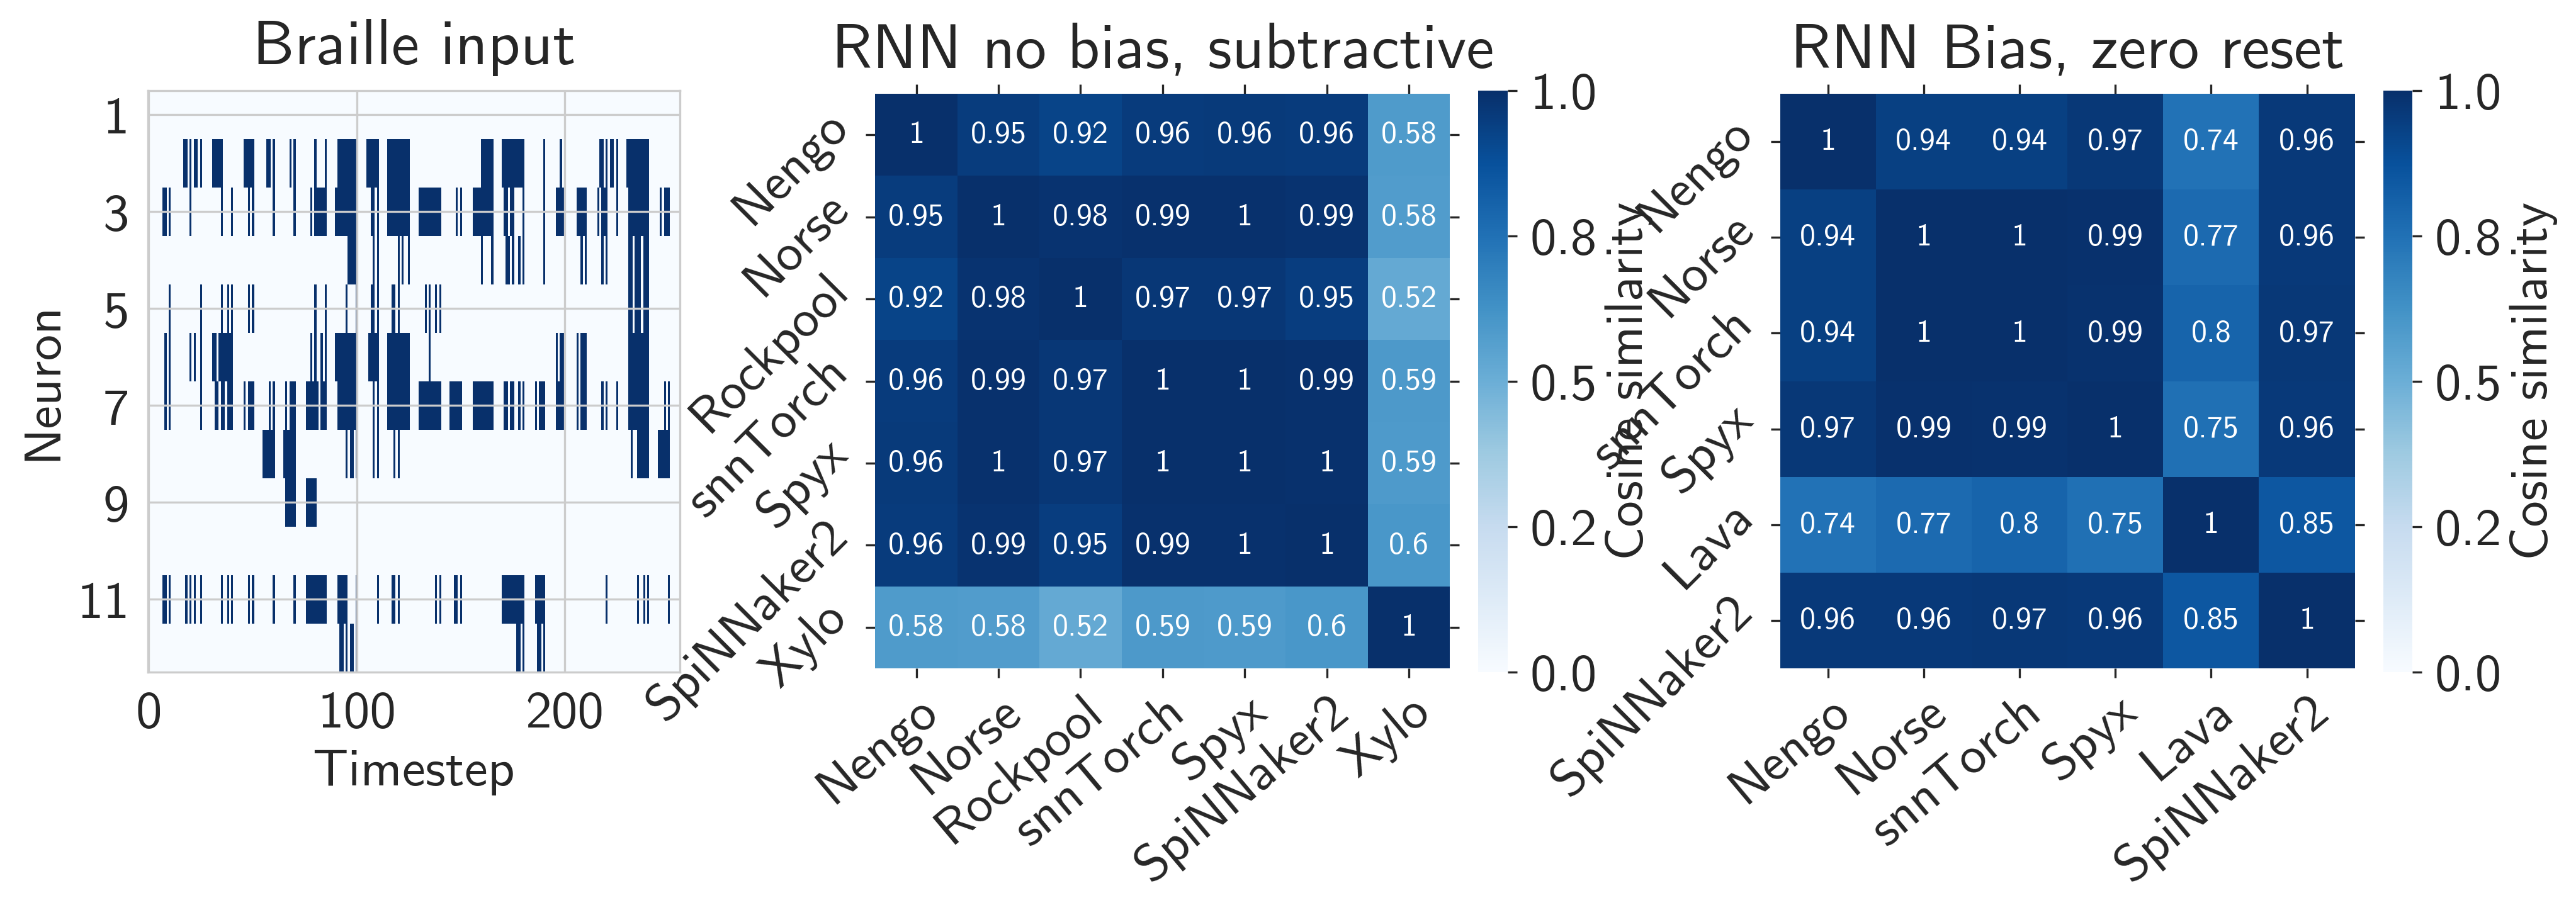

In [15]:
f, (a0, a1, a2) = plt.subplots(1, 3, figsize=(16, 4), dpi=300, width_ratios=[0.3, 0.4, 0.4], gridspec_kw={"wspace": 0.3})
plot_similarities(act_sub, a1)
plot_similarities(act_zero, a2)

a0.set_title("Braille input", pad=10)
a1.set_title("RNN no bias, subtractive", pad=10)
a2.set_title("RNN Bias, zero reset", pad=10)

a0.imshow(d.T, cmap="Blues", aspect="auto", interpolation="none")
a0.set_xlabel("Timestep")
a0.set_ylabel("Neuron")
a0.set_yticks(range(0, 12, 2), range(1, 13, 2))

for a in [a1, a2]:
    a.collections[0].colorbar.set_label("Cosine similarity", labelpad=3)
    a.collections[0].colorbar.ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.1f"))
    a.collections[0].colorbar.ax.tick_params(pad=5)
    a.xaxis.set_ticks_position("both")
    plt.setp(a.get_xticklabels(), rotation=40, va="top", ha="right", rotation_mode="anchor")
    a.yaxis.set_ticks_position("both")
    plt.setp(a.get_yticklabels(), rotation=45, va="bottom", ha="right", rotation_mode="anchor")

f.savefig("../figures/rnn_similarity.pdf", bbox_inches="tight")

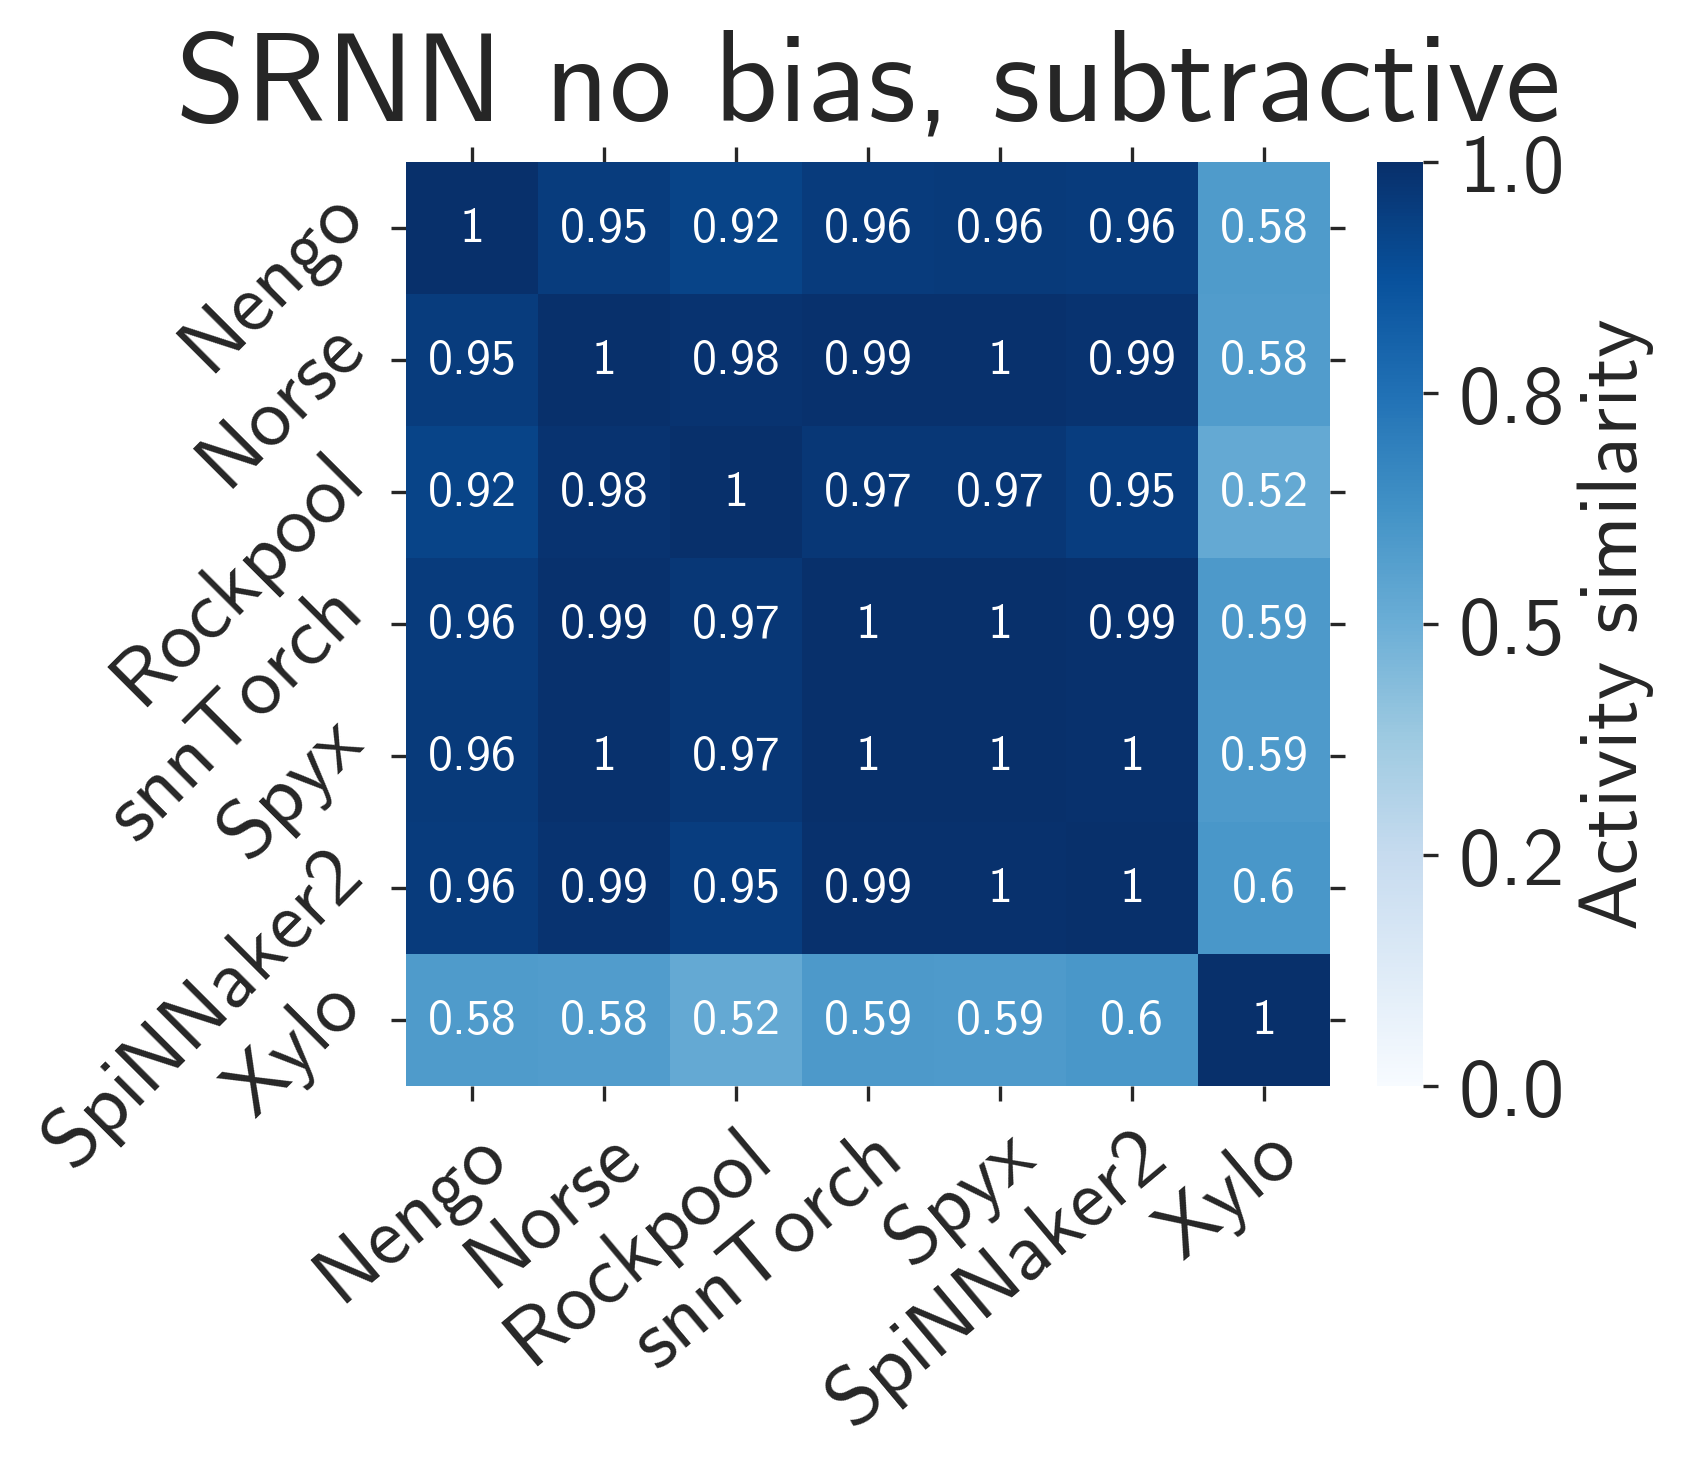

In [16]:
f, a = plt.subplots(1, 1, figsize=(5, 4), dpi=300)
plot_similarities(act_sub, a)
a.collections[0].colorbar.set_label("Activity similarity", labelpad=3)
a.collections[0].colorbar.ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.1f"))
a.collections[0].colorbar.ax.tick_params(pad=5)
a.xaxis.set_ticks_position("both")
plt.setp(a.get_xticklabels(), rotation=40, va="top", ha="right", rotation_mode="anchor")
a.yaxis.set_ticks_position("both")
plt.setp(a.get_yticklabels(), rotation=45, va="bottom", ha="right", rotation_mode="anchor")
a.set_title("SRNN no bias, subtractive", pad=10, fontsize=30)
f.savefig("../figures/rnn_nobias.pdf", bbox_inches="tight")

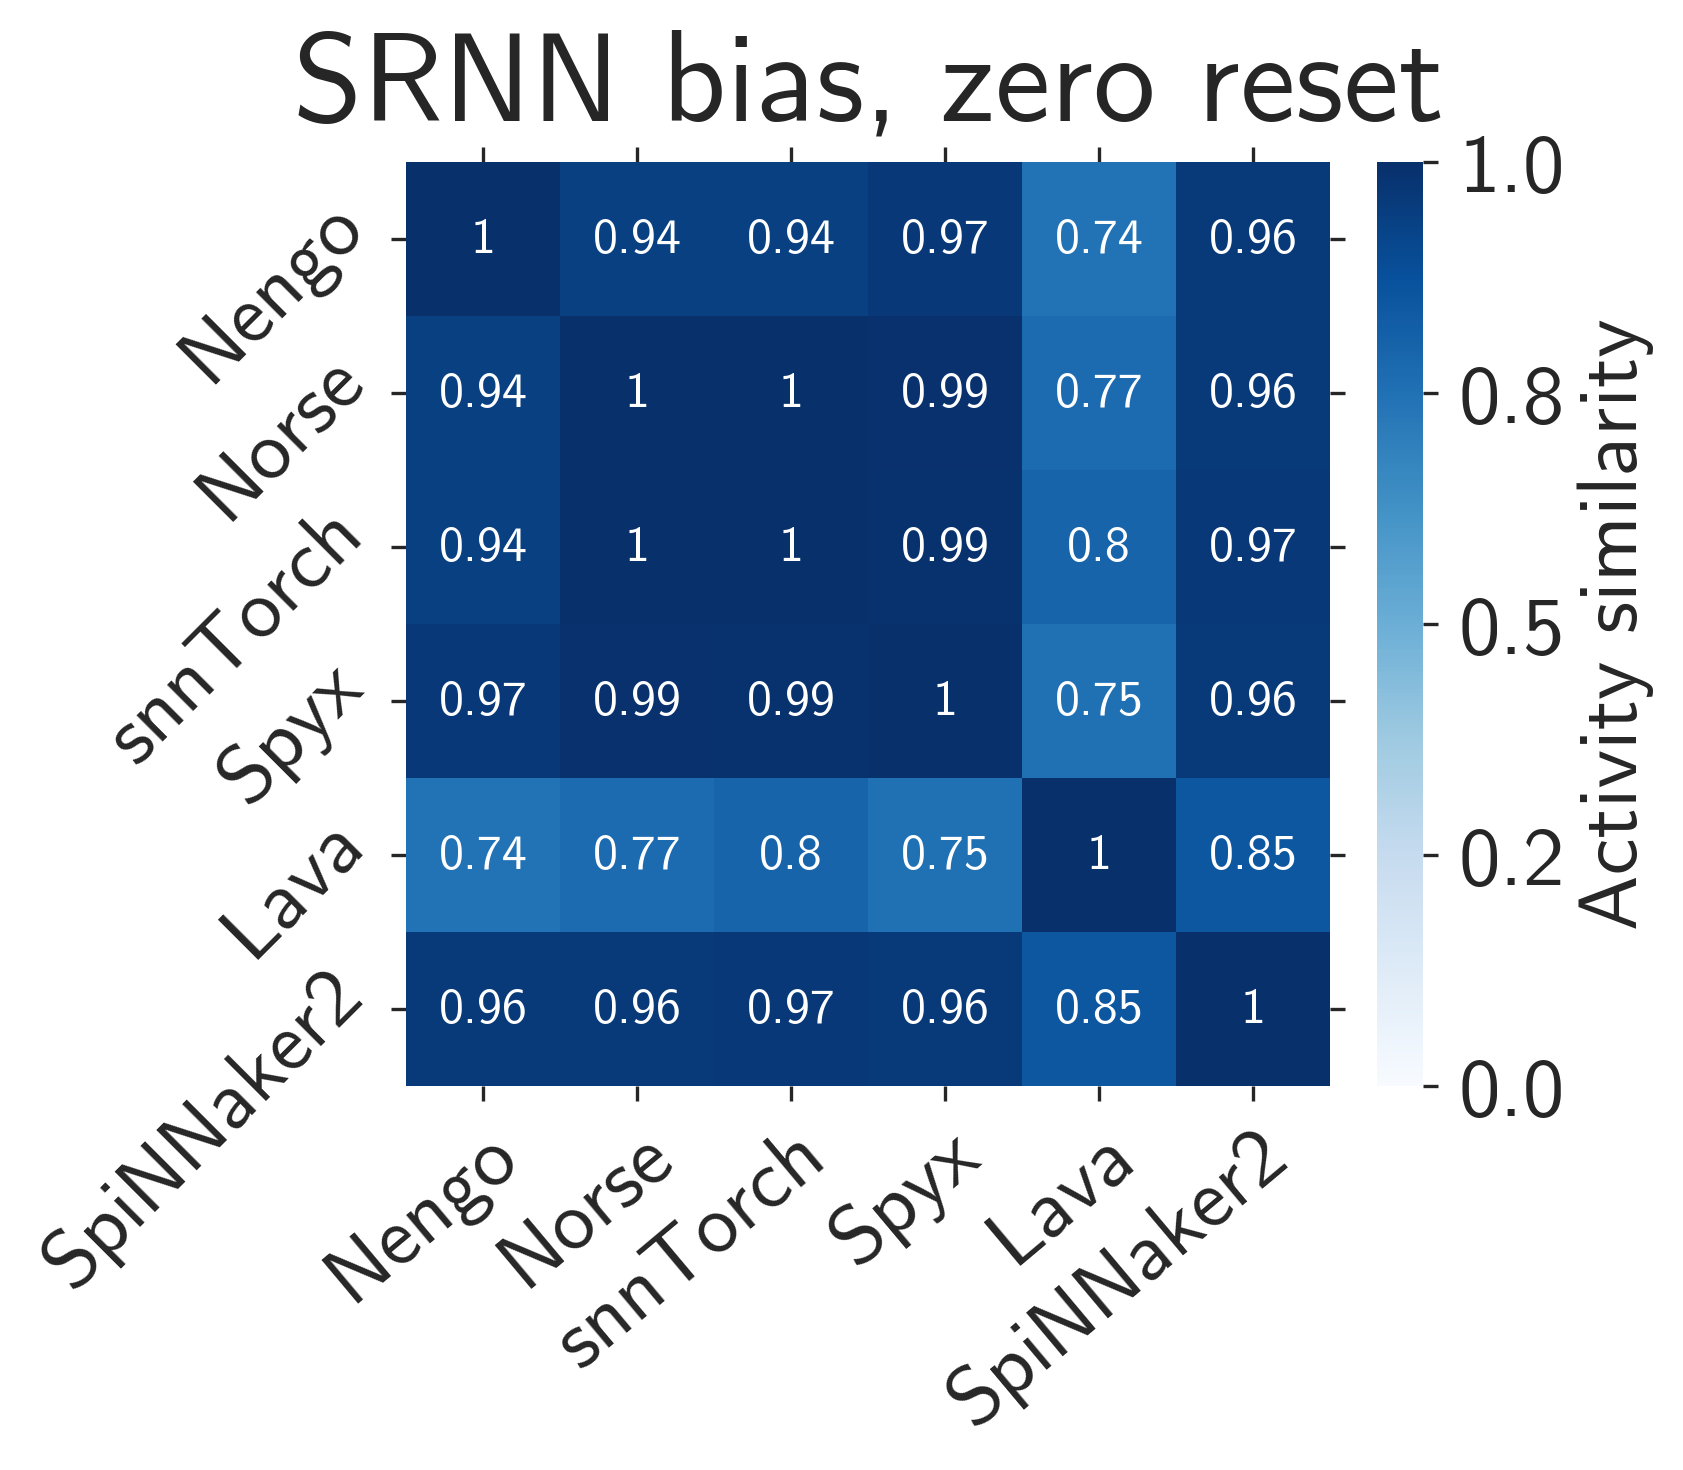

In [17]:
f, a = plt.subplots(1, 1, figsize=(5, 4), dpi=300)
plot_similarities(act_zero, a)
a.collections[0].colorbar.set_label("Activity similarity", labelpad=3)
a.collections[0].colorbar.ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.1f"))
a.collections[0].colorbar.ax.tick_params(pad=5)
a.xaxis.set_ticks_position("both")
plt.setp(a.get_xticklabels(), rotation=40, va="top", ha="right", rotation_mode="anchor")
a.yaxis.set_ticks_position("both")
plt.setp(a.get_yticklabels(), rotation=45, va="bottom", ha="right", rotation_mode="anchor")
a.set_title("SRNN bias, zero reset", pad=10, fontsize=30)
f.savefig("../figures/rnn_bias.pdf", bbox_inches="tight")

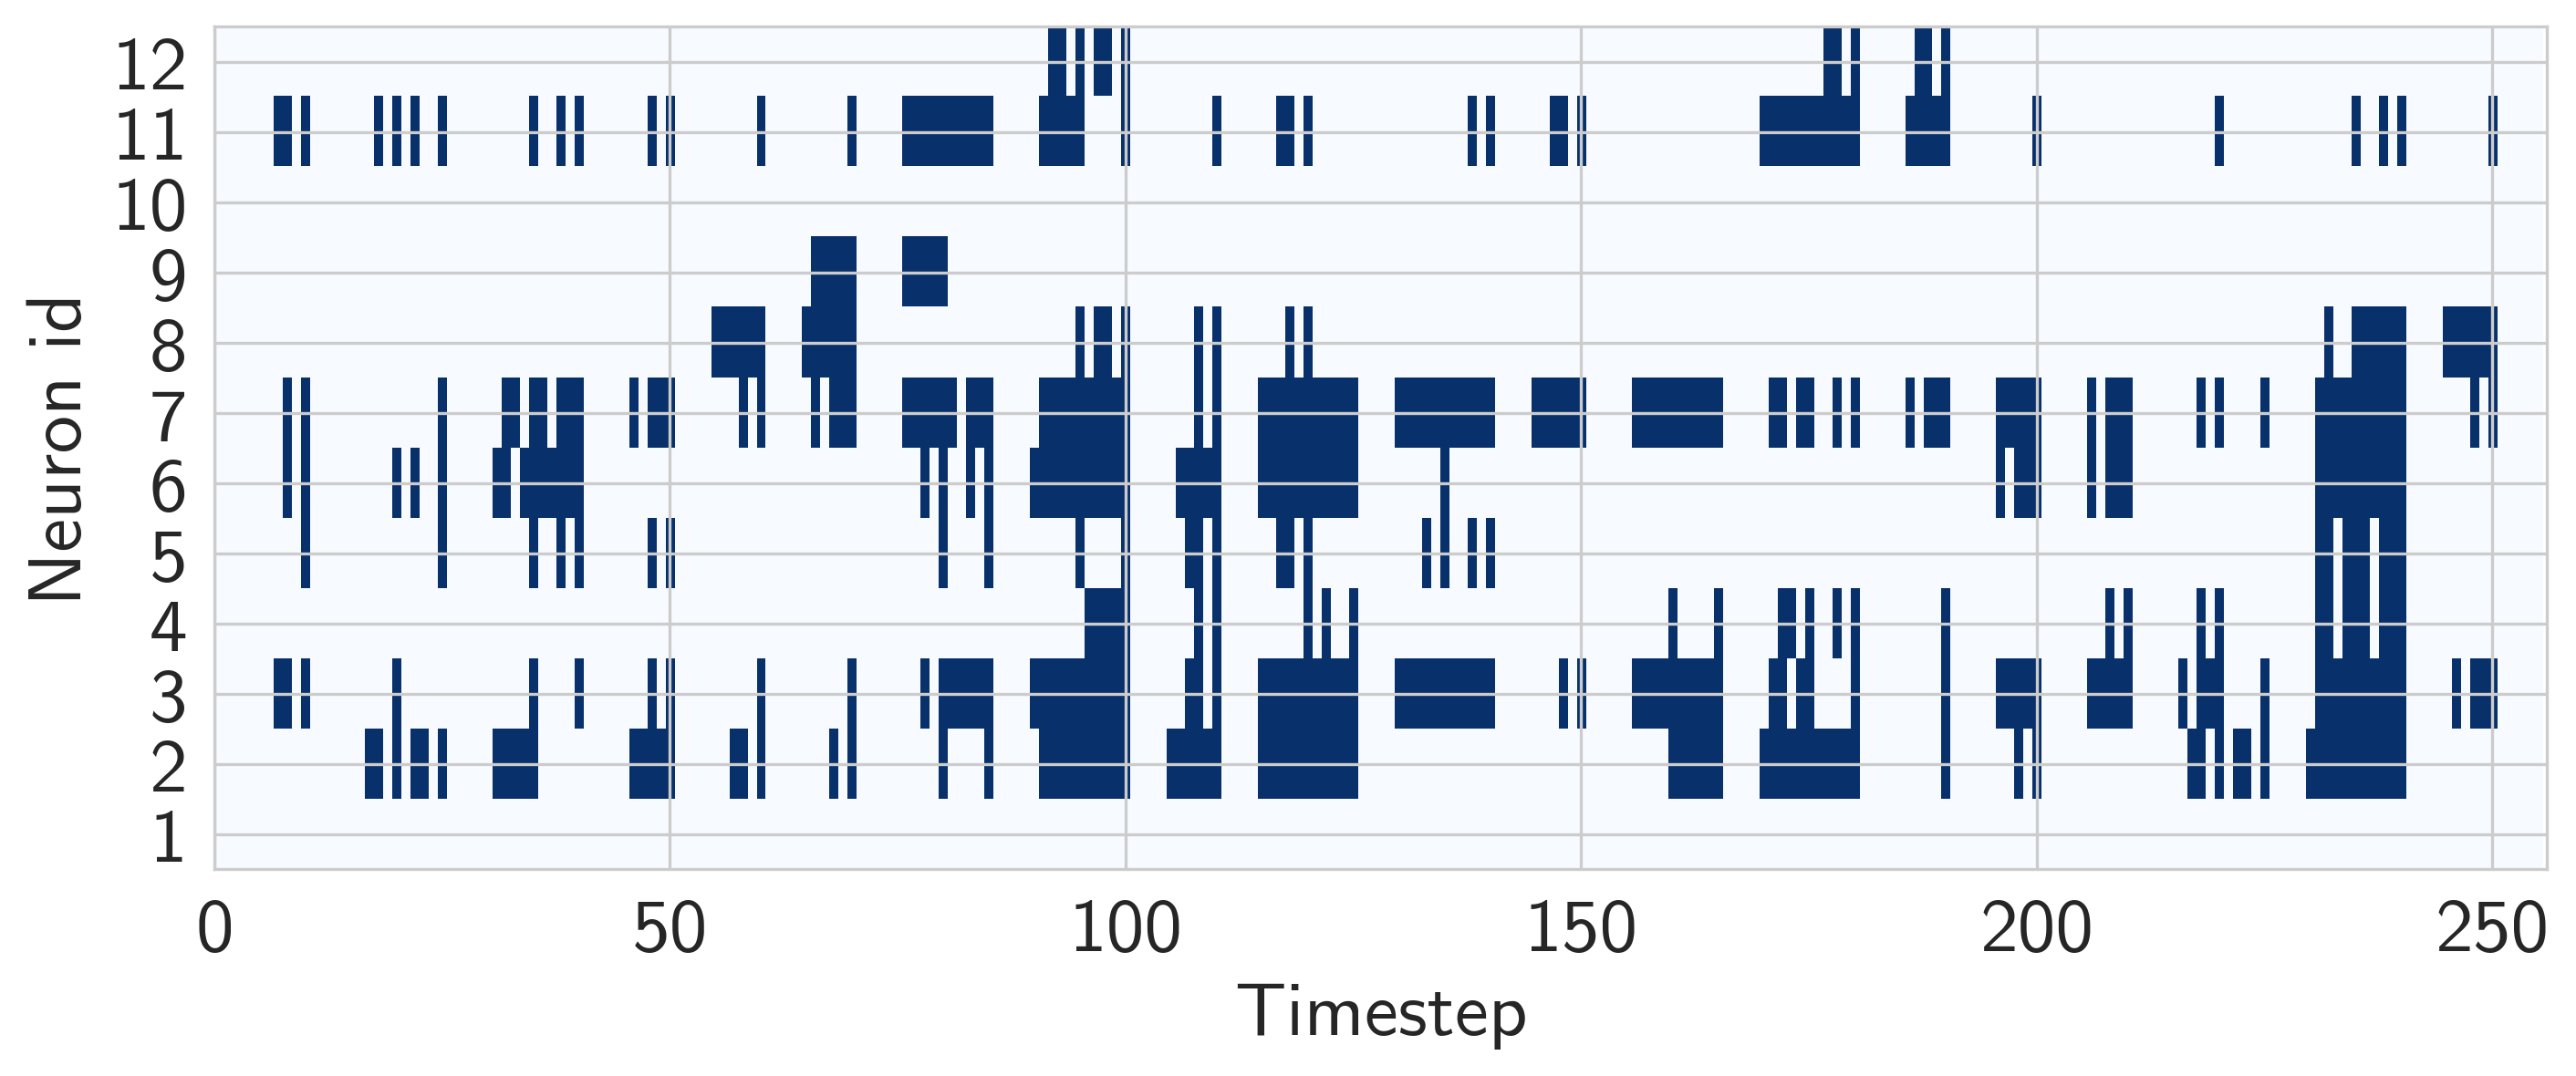

In [18]:
f, a0 = plt.subplots(1, 1, figsize=(11, 4), dpi=300)

a0.imshow(d.T, cmap="Blues", aspect="auto", interpolation="none")
# a0.set_title("Braille", pad=10, fontsize=30)
a0.set_xlabel("Timestep")
a0.set_ylabel("Neuron id")
a0.set_xlim(0, 256)
a0.set_ylim(-0.5, 11.5)
a0.set_yticks(range(0, 12, 1), range(1, 13, 1))
# a0.
f.savefig("../figures/braille_input.pdf", bbox_inches="tight")